## **提出的方法**

我们对严重缺失模态的多模态学习感兴趣，例如，训练样本中90%的样本包含不完整的模态。在本文中，为了不失一般性，我们考虑一个包含两个模态的多模态数据集。形式上，我们让 $\mathcal{D} = \{\mathcal{D}^f, \mathcal{D}^m\}$ 表示一个多模态数据集；$\mathcal{D}_1^f = \left\{ \mathbf{x}_i^1, \mathbf{x}_i^2, y_i \right\}_i$ 是一个模态完整的数据集，其中 $\mathbf{x}_i^1$ 和 $\mathbf{x}_i^2$ 表示第 $i$ 个样本的两个不同模态，$y_i$ 是相应的类别标签；$\mathcal{D}^m = \{\mathbf{x}_j^1, y_j\}_j$ 是一个模态不完整的数据集，其中一个模态缺失。我们的目标是利用模态完整和模态不完整的数据进行模型训练。我们从两个角度提出解决这个问题的方法：

1) 灵活性：如何在训练、测试或两者中统一处理缺失模态？

2) 效率：当主要数据遭受缺失模态时，如何提高训练效率？

**灵活性**。我们的目标是实现一个统一的模型，能够处理训练、测试或两者中的缺失模态。我们的想法是使用一个特征重建网络来实现这个目标。与传统的数据重建方法（Lee等人，2019；Tran等人，2017）不同，特征重建网络将利用可用模态以高度高效的方式生成缺失模态特征的近似值。这将在潜在特征空间中生成完整数据，并在两个方面促进灵活性。一方面，我们的模型可以通过使用模态完整和不完整的数据进行联合训练，挖掘混合数据的全部潜力。另一方面，在测试时，通过打开或关闭特征重建网络，我们的模型可以以统一的方式处理模态不完整或完整的输入。

**效率**。我们旨在在模态严重缺失的数据集上训练一个模型，以实现与在完整模态数据集上训练的模型相当的性能。然而，模态严重缺失的设置给特征重建网络带来了显著的学习挑战。由于模态完整数据的稀缺性，网络可能会高度偏向，产生退化和低质量的特征生成。直接使用退化和低质量的特征训练模型将阻碍训练过程的效率。我们提出了一种特征正则化方法来解决这个问题。我们的想法是利用贝叶斯神经网络通过执行特征扰动来评估数据的不确定性。不确定性评估用作特征正则化，以克服模型和数据偏差。与先前的确定性正则化方法（Balaji，Sankaranarayanan和Chellappa，2018；Zhao等人，2020）相比，所提出的不确定性引导特征正则化将显著提高多模态模型在处理严重不完整数据时的鲁棒泛化能力。

**元学习框架**。为了有效地组织模型训练，我们在一个修改后的模型无关元学习（MAML）（Finn，Abbeel和Levine，[2017]）框架中整合了由 $\theta$ 参数化的主网络 $f_\theta$、由 $\phi_c$ 参数化的重建网络 $f_{\phi_c}$ 和由 $\phi_r$ 参数化的正则化网络 $f_{\phi_r}$。我们学习框架的概述如图2所示。在以下部分中，我们描述了特征重建和正则化网络的实现。


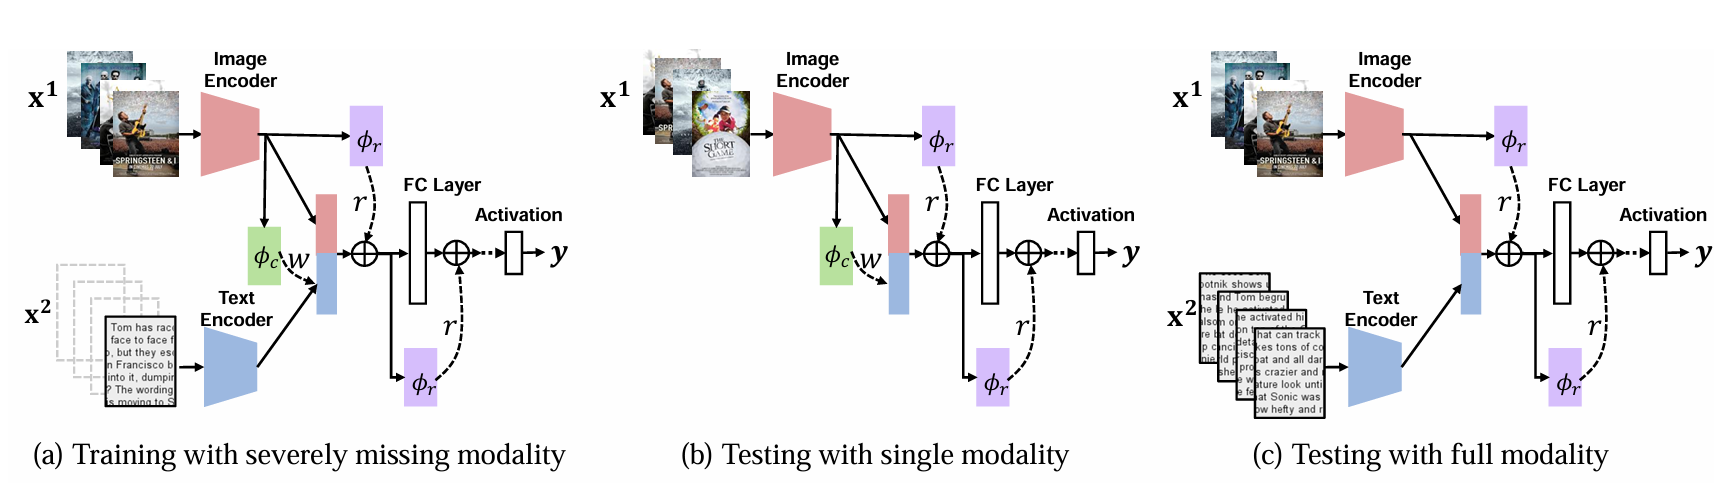


---

**图2**：SMIL能够从严重缺失模态的数据中进行统一学习，并在测试时使用单个或完整模态。**重建网络** $\phi_c$ 输出一个后验分布，从中我们采样权重 $\omega$ 来使用模态先验重建缺失模态。**正则化网络** $\phi_r$ 也输出一个后验分布，从中我们采样正则化器 $r$ 来扰动潜在特征以实现平滑嵌入。$\phi_c$ 和 $\phi_r$ 的协作确保了灵活且高效的学习。

---


## **缺失模态重建**

我们引入特征重建网络来近似缺失模态。对于一个模态不完整的样本，缺失模态根据可用模态进行重建。给定观察到的模态 $\mathbf{x}^1$，为了获得缺失模态的重建 $\hat{\mathbf{x}}^2$，我们为重建网络优化以下目标：

（1）

$$\phi_c^* = \arg\min_{\phi_c} \mathbf{E}_{p(\hat{\mathbf{x}}^1, \mathbf{x}^2)}(-\log p(\hat{\mathbf{x}}^2 | \mathbf{x}^1; \phi_c)).$$

然而，在模态严重缺失的情况下，从有限的模态完整样本中训练一个重建网络并不容易。受（Kuo等人，2019）的启发，我们使用从模态完整数据集中学习的模态先验的加权和来近似缺失模态。在这种情况下，重建网络被训练为预测先验的权重，而不是直接生成缺失模态。我们通过学习一组模态先验 $\mathcal{M}$ 来实现这一点，这些先验可以使用K-means（MacQueen，1967）或PCA（Pearson，[1901]）在所有模态完整样本中进行聚类。

具体来说，让 $\omega$ 表示分配给每个模态先验的权重。我们将 $\omega$ 建模为一个具有固定均值和可变方差的多元高斯分布，即 $\mathcal{N}(\mathbf{I}, \boldsymbol{\sigma})$。方差由特征重建网络预测，即 $\boldsymbol{\sigma} = f_{\phi_c}(\tilde{\mathbf{x}^{\hat{1}}})$。给定权重 $\omega$，我们可以通过计算模态先验的加权和来重建缺失模态 $\hat{\mathbf{x}}^2$。然后，重建的缺失模态可以通过以下方式获得：

$$\hat{\mathbf{x}}^2 = \left\langle \boldsymbol{\omega}, \mathcal{M} \right\rangle, \text{其中} \boldsymbol{\omega} \sim \mathcal{N}(\mathbf{I}, \boldsymbol{\sigma}).$$

（2）

我们注意到，将 $\omega$ 建模为多元随机变量为重建过程引入了随机性和不确定性，这已被证明在学习复杂分布时是有益的（Lee等人，2020b）。

## **不确定性引导的特征正则化**

我们提出通过一个特征正则化网络来正则化潜在特征。在每一层中，正则化网络将前一层的特征作为输入，并对当前层的特征应用正则化。令 $r$ 表示生成的正则化，$h^l$ 表示第 $l$ 层的潜在特征。与生成确定性正则化 $\mathbf{r} = f_{\phi_r}(\mathbf{h}^{l-1})$ 不同，我们假设 $r$ 服从多元高斯分布 $\mathcal{N}(\boldsymbol{\mu}, \sigma)$，其中均值和方差使用 $(\boldsymbol{\mu}, \boldsymbol{\sigma}) = f_{\phi_r}(\mathbf{h}^{l-1})$ 计算。然后，我们可以通过以下方程计算正则化特征：

$$\mathbf{h}^l := \mathbf{h}^l \circ \mathrm{Softplus}(\mathbf{r}), \quad \text{其中} \quad \mathbf{r} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}),$$

（3）

其中 $\circ$ 是预定义的操作（加法或乘法），用于特征正则化。在我们的实验中，我们观察到直接对潜在特征应用正则化将阻止特征正则化网络收敛。因此，我们采用 Softplus（Dugas等人，[2000]）激活函数来减弱正则化。



## **贝叶斯元学习框架**

我们利用一个贝叶斯元学习框架来联合优化所有网络。具体而言，我们在 $D^m$ 上元训练主网络 $f_\theta$，并在重建网络 $f_{\phi_c}$ 和正则化网络 $f_{\phi_r}$ 的帮助下进行。然后，我们在 $D^f$ 上元测试更新后的主网络 $f_{\theta^*}$。最后，我们通过梯度下降来元更新网络参数 $\{\theta, \phi_c, \phi_r\}$。为了简单起见，我们让 $\psi = \{\phi_c, \phi_r\}$ 表示重建和正则化网络参数的组合。我们的框架旨在优化以下目标函数：

$$\min_{\theta, \psi} \mathcal{L}(\mathcal{D}^f; \theta^*, \psi),$$

（4）

对于上述函数，$\mathcal{L}$ 表示经验损失，如交叉熵，$\alpha$ 是内循环步长。

我们使用 $\hat{\mathbf{X}}$ 和 $Y$ 分别表示所有训练样本及其相应的标签。令 $z = \{\omega, \mathbf{r}\}$ 表示生成的权重和正则化的集合。然后，受（Finn，Xu和Levine，[2018]；Gordon等人，2019；Lee等人，[2020a]）的启发，我们将生成过程定义为在元学习框架中优化似然：

$$p(\mathbf{Y}, \mathbf{z} | \mathbf{X}; \boldsymbol{\theta}) = p(\mathbf{z}) \prod_{i=1}^{N} p(\boldsymbol{y}_i | \mathbf{x}_i^1, \mathbf{x}_i^2, \mathbf{z}; \boldsymbol{\theta}) \prod_{j=1}^{M} p(\boldsymbol{y}_j | \mathbf{x}_j^1, \mathbf{z}; \boldsymbol{\theta}).$$

贝叶斯元学习的目标是通过最大化条件似然来优化模型：$\log p(\mathbf{Y} | \mathbf{X}; \boldsymbol{\theta})$。然而，解决这个问题涉及真实的后验 $p(\mathbf{z} | \mathbf{X})$，这是难以处理的。相反，我们通过一个mortized分布 $q(\mathbf{z} | \mathbf{X}; \hat{\psi})$（Finn，Xu和Levine，2018；Gordon等人，2019；Lee等人，2020a）来近似真实的后验分布。我们元学习框架的近似下界形式可以定义为：

$$\mathcal{L}_{\boldsymbol{\theta}, \boldsymbol{\psi}} = \mathbf{E}_{q(\mathbf{z} | \mathbf{X}; \boldsymbol{\theta}, \boldsymbol{\psi})}[\log p(\mathbf{Y} | \mathbf{X}, \mathbf{z}; \boldsymbol{\theta})] - \mathrm{KL}[q(\mathbf{z} | \mathbf{X}; \boldsymbol{\psi}) \| p(\mathbf{z} | \mathbf{X})].$$

（6）

我们通过蒙特卡罗（MC）采样来最大化这个下界。将所有这些结合在一起，我们得到所提出的元学习框架的完整训练目标，用于 $\theta$ 和 $\psi$，定义为：

$$\min_{\theta, \psi} \frac{1}{L} \sum_{l=1}^{L} -\log p(y_j | x_1^j, x_2^j, z_l; \theta) + \mathrm{KL}(q(z | \mathbf{x}; \boldsymbol{\psi}) \| p(z | \mathbf{X}))$$

其中 $z_i \sim q(z | \mathbf{x}_i; \boldsymbol{\psi})$，

其中 $L$ 是MC采样的数量。我们在算法[1]中展示了详细的算法。

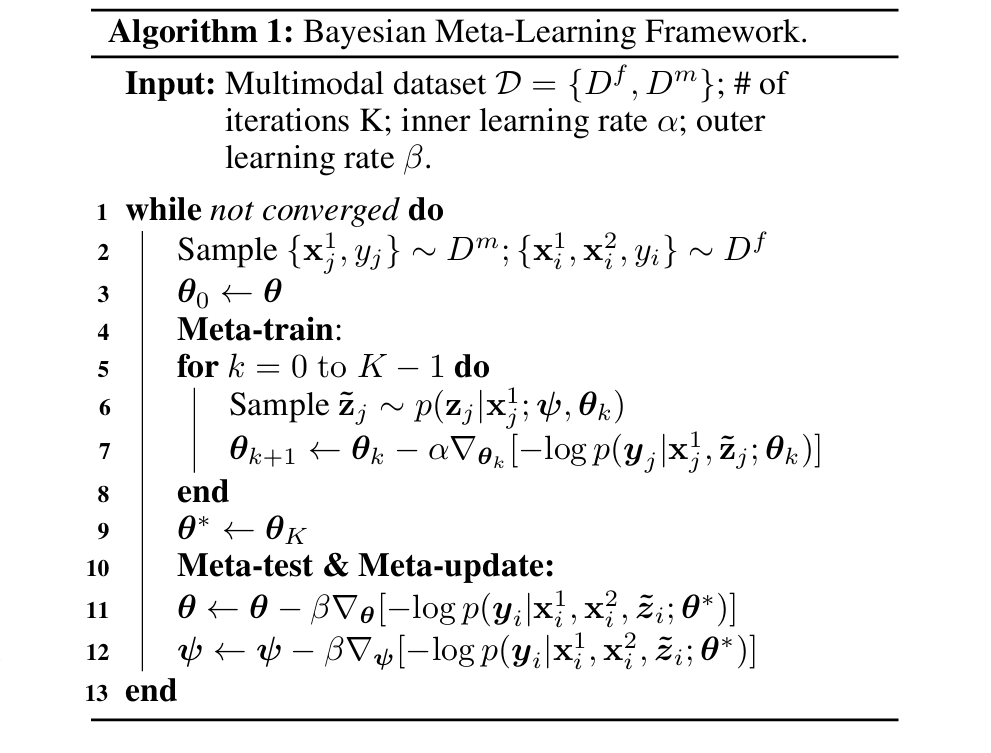